# eqGAN Training Notebook

An attempt to perform automatic music mastering using a Generative Adversarial Network

### Make sure that these constants are set correctly!

In [1]:
# Constants
USING_GPU = True
AVAILABLE_GPUS="0,1,2,3,4,5"
CUDANO = 0

D_LR = 1e-3
G_LR = 1e-3
EPOCHS = 10
IS_DIRECT = False # Direct or Indirect Reconstruction (See Paper for more details)
SAMPLE_LENGTH = 110229 # Less than 661794


RUN_NAME = 'cnn_gan_run_1'

You should (hopefully) be able to run the rest of the cells without editing anything

In [2]:
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import numpy as np

/lfs/turing2/0/frg100/gpuvenv/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Download the dataset

In [23]:
# Construct a torch.utils.data.Dataset and DataLoader
gtzan_data = torchaudio.datasets.GTZAN('.', download=False)

def collate_fn(batch):
    # Takes in a list (batch) of samples (waveform, sample_rate, label)
    batch_size = len(batch)
    waveforms = []
    for waveform, sample_rate, label in batch:
        if waveform.size(1) == 661794:
            waveforms.append(waveform)
        elif waveform.size(1) > 661794:
            waveforms.append(waveform[:,:661794])
        else:
            diff = 661794 - waveform.size(1)
            waveforms.append(torch.nn.functional.pad(waveform,(0,diff)))
            
        
    waveform_batch = torch.stack(waveforms, dim=0)
    # Returns a tuple collated with sizes (torch.Size([batch_size, 1, 661794]), )
    return waveform_batch, sample_rate, label

gtzan_loader = torch.utils.data.DataLoader(gtzan_data, batch_size=10, shuffle=False, num_workers=6, collate_fn=collate_fn)

In [24]:
def visualize_wav(waveform, domain='time'):
    """
    A function to visualize a waveform in the time or frequency domain
    """
    wav = torch.squeeze(waveform, dim=0)
    if domain == 'freq':
        plt.figure(figsize=(50,30))
        specgram = torchaudio.transforms.Spectrogram()(wav)
        plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')
    elif domain == 'time':
        plt.figure()
        plt.plot(wav.t().numpy())
    else:
        print('Invalid domain')

Shape of waveform: torch.Size([10, 1, 661794])
Sample rate of waveform: 22050


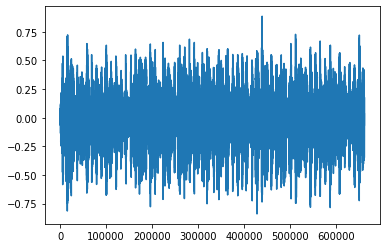

In [25]:
# Show a single example
example_wav, example_sr = None, None
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))
    example_wav, example_sr = waveform[0,:,:], sample_rate

    visualize_wav(waveform[0,:,:])
    break

### Implement EQ operations

In [26]:
# Define the EQ transform
from scipy.stats import loguniform

class RandomEQ(object):
    """EQ the waveform in a sample randomly.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, sample_rate):
        assert isinstance(sample_rate, (float, int))
        self.sample_rate = sample_rate
        
        # EQ Constants
        self.FREQ_RANGE = [0.01, 20] # in kHZ
        self.GAIN_RANGE = [-15, 15] # in dB
        self.Q_RANGE = [0.1, 18]

    def __call__(self, waveform, verbose=False):
        # TODO: Make some of these normals
        center_freq = loguniform.rvs(self.FREQ_RANGE[0], self.FREQ_RANGE[1])
        gain = np.random.uniform(self.GAIN_RANGE[0], self.GAIN_RANGE[1])
        Q = np.random.uniform(self.Q_RANGE[0], self.Q_RANGE[1])

        center_freq = 1
        gain = -10
        Q = 1
        
        if verbose:
            print(
                f"Applying random EQ with center frequency of ",
                f"{center_freq} kHZ, gain of {gain} dB, and Q = {Q}"
            )

        equalized_waveform = torchaudio.functional.equalizer_biquad(
            waveform, self.sample_rate,
            center_freq=center_freq*1e3, gain=gain, Q=Q
        ) 

        return equalized_waveform

Shape of waveform: torch.Size([10, 1, 661794])
Sample rate of waveform: 22050


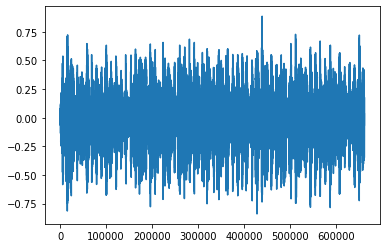

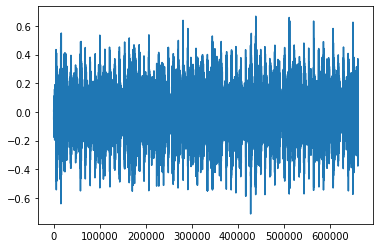

In [27]:
# Show a single example
eq_transform = RandomEQ(example_sr)
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    visualize_wav(waveform[0,:,:])
    visualize_wav(eq_transform(waveform[0,:,:]))
    break

### Learn an EQ operation

We want to test whether or not we can have a model learn an EQ operation by reconstructing the non-equalized version of the waveform

In [28]:
import os

device = 'cpu'

if USING_GPU:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]=AVAILABLE_GPUS
    device = f'cuda:{CUDANO}'

if not os.path.exists(f"EQ/{RUN_NAME}"):
    os.mkdir(f"EQ/{RUN_NAME}")

In [201]:
import torch.fft as fft

class EQReconstructor(torch.nn.Module):
    def __init__(self, sample_rate, sample_length, direct=False):
        """
        In the constructor we instantiate the layers
        """
        super().__init__()
        
        # Params
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        self.direct = direct
        self.indirect = not direct

        # Audio transforms
        self.synthetic_transform = RandomEQ(self.sample_rate)       
        self.specgram = torchaudio.transforms.Spectrogram()
        
        # CNN Layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7, padding=3) #p = (f-1)/2
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=1, kernel_size=7, padding=3)
        self.fc1 = torch.nn.Linear(100 * 276, 120)
        self.fc2 = torch.nn.Linear(120, SAMPLE_LENGTH)

    def forward(self, waveform):
        """
        In the forward function we accept an input waveform, apply a random
        EQ, and then try to reconstruct it.
        
        Params:
            waveform is an audio wav of shape [batch_size, 1, length]
        """
        # print("Pre-processing wav")
        #print(f"waveform.shape: {waveform.shape}")
        with torch.no_grad():
            equalized_wav = self.synthetic_transform(waveform)
            
        # Turn audio into spectrogram
        specgram = self.specgram(equalized_wav) #torch.Size([batch_size, 1, 201, 552])
        
        # Run spectrogram through CNN 
        x = specgram
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.pool(torch.nn.functional.relu(x))

        if self.direct:
            # Generate output spectrogram
            # Turn output spectrogram back into audio
            reconstructed_wav = waveform

        if self.indirect:
            # Use output to generate a filter kernel
            x = x.view(-1, 100 * 276)
            x = torch.nn.functional.relu(self.fc1(x))
            x = torch.nn.functional.relu(self.fc2(x))
            kernel = x.view(-1, waveform.shape[-1]) #[batch, n_frames, n_impulse_response] n_f * n_imp = waveform.shape(-1) [110,229]
            
            # Apply the filter kernel
            #print(f"equalized_wav.shape: {equalized_wav.shape}")
            signal = torch.nn.functional.pad(equalized_wav, (0, equalized_wav.shape[-1]))
            #print(f"signal.shape: {signal.shape}")
            kernel = torch.nn.functional.pad(kernel, (kernel.shape[-1], 0))
            #print(f"kernel.shape: {kernel.shape}")

            output = fft.irfft(fft.rfft(signal) * fft.rfft(kernel))
            #print(f"output.shape: {output.shape}")
            output = output[..., output.shape[-1] // 2:]
            output = torch.mean(output, dim=-2, keepdim=True)
            #print(f"output.shape: {output.shape}")
            
            reconstructed_wav = output
            
        return reconstructed_wav

In [202]:
criterion = torch.nn.MSELoss()
def loss_function(output, waveform):
    """
    Here we define the loss function that the model will try to optimize.
    In this case, a simple reconstruction loss
    """
    reconstructed_wav = output
    loss = criterion(waveform, reconstructed_wav)
    return loss

In [203]:
class EQEvaluator(torch.nn.Module):
    def __init__(self, sample_rate, sample_length):
        """
        In the constructor we instantiate the layers
        """
        super().__init__()
        
        # Params
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        
        # Audio transforms
        self.specgram = torchaudio.transforms.Spectrogram()
        
        # CNN Layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7, padding=3) #p = (f-1)/2
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=1, kernel_size=7, padding=3)
        self.fc1 = torch.nn.Linear(100 * 276, 120)
        self.fc2 = torch.nn.Linear(120, 1)

    def forward(self, waveform):
        """
        In the forward function we accept an input waveform, run it through
        an LSTM, and decide if it's mastered or unmastered
        """
        
        # Turn audio into spectrogram
        specgram = self.specgram(waveform) #torch.Size([batch_size, 1, 201, 552])
        
        # Run spectrogram through CNN 
        x = specgram
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.pool(torch.nn.functional.relu(x))
        
        # Use output to generate the final prediction
        x = x.view(-1, 100 * 276)
        x = torch.nn.functional.relu(self.fc1(x))
        logit = torch.nn.functional.relu(self.fc2(x))
        
        return logit

In [204]:
generator = EQReconstructor(sample_rate=22050, sample_length=SAMPLE_LENGTH, direct=IS_DIRECT).to(device) 
discriminator = EQEvaluator(sample_rate=22050, sample_length=SAMPLE_LENGTH).to(device)
gen_optimizer = torch.optim.SGD(generator.parameters(), lr=G_LR)
disc_optimizer = torch.optim.SGD(discriminator.parameters(), lr=D_LR)

bce_loss = torch.nn.BCEWithLogitsLoss()

num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    print("Let's use", num_gpus , "GPUs!")
    generator = torch.nn.DataParallel(generator)
    discriminator = torch.nn.DataParallel(discriminator)
    
for i in range(num_gpus):
    print("Device ", i, torch.cuda.get_device_name(i))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,1), 'GB')
    
# print(os.popen("source cuda10.0").read())

# print(os.popen("nvidia-htop.py").read())
# print(os.popen("nvidia-smi").read())

Let's use 6 GPUs!
Device  0 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.4 GB
Device  1 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Device  2 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Device  3 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Device  4 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Device  5 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Epoch 0/10
Processing batch 1/100


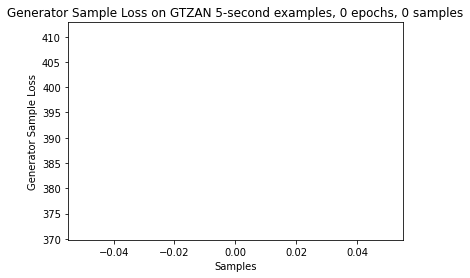

Processing batch 2/100
Processing batch 3/100
Processing batch 4/100
Processing batch 5/100
Processing batch 6/100
Processing batch 7/100
Processing batch 8/100
Processing batch 9/100
Processing batch 10/100
Processing batch 11/100


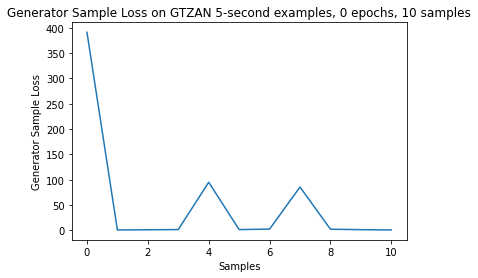

Processing batch 12/100
Processing batch 13/100
Processing batch 14/100
Processing batch 15/100
Processing batch 16/100
Processing batch 17/100
Processing batch 18/100
Processing batch 19/100
Processing batch 20/100
Processing batch 21/100


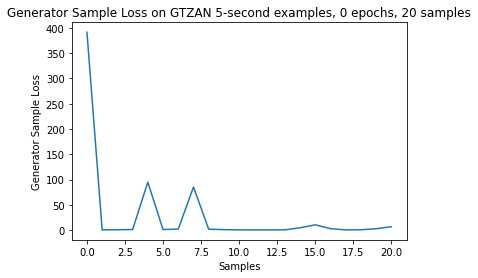

Processing batch 22/100
Processing batch 23/100
Processing batch 24/100
Processing batch 25/100
Processing batch 26/100
Processing batch 27/100
Processing batch 28/100
Processing batch 29/100
Processing batch 30/100
Processing batch 31/100


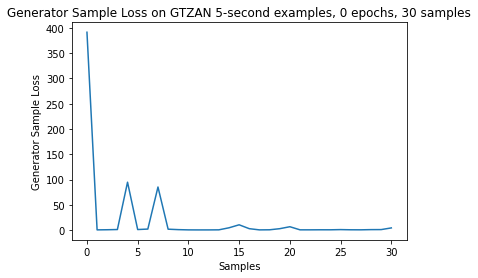

Processing batch 32/100
Processing batch 33/100


KeyboardInterrupt: 

In [207]:
losses = {
    'generator': {
        'epoch': [],
        'sample': []
    },
    'discriminator': {
        'epoch': [],
        'sample': []
    }
}
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}/{EPOCHS}")
    
#     # Train Discriminator
#     print("Training Discriminator on real samples and fake reconstructed samples")
#     losses['discriminator']['epoch'].append(0)
#     for idx, batch in enumerate(gtzan_loader):
#         # Extract data
#         print(f"Processing batch {idx+1}/{len(gtzan_loader)}")
#         waveform, sample_rate, label = batch

#         # Forward pass
#         real = torch.transpose(waveform, 0, -1)
#         real = torch.transpose(real, -2, -1)
#         real = real[:SAMPLE_LENGTH,:,:].to(device)
#         fake = generator(real).detach()
        
#         # Get logits for both real and fake
#         fake_logits = discriminator(fake)
#         real_logits = discriminator(real)
        
#         # Compute loss
#         fake_loss = bce_loss(fake_logits, torch.zeros_like(fake_logits))
#         real_loss = bce_loss(real_logits, torch.ones_like(real_logits))
#         loss = (fake_loss + real_loss)/2
#         losses['discriminator']['epoch'][-1] += loss.item()
#         losses['discriminator']['sample'].append(loss.item())
        
#         if idx % 10 == 0:
#             plt.plot(losses['discriminator']['sample'])
#             plt.ylabel('Discriminator Sample Loss')
#             plt.xlabel('Samples')
#             plt.title(f'Discriminator Sample Loss on GTZAN 5-second examples, {epoch} epochs, {idx} samples')
#             plt.show()

#             torch.save({
#                 "models": {
#                     "generator": generator.state_dict(),
#                     "discriminator": discriminator.state_dict()
#                 },
#                 "optimizers": {
#                     "generator": gen_optimizer.state_dict(),
#                     "discriminator": disc_optimizer.state_dict()
#                 },
#                 "hyperparameters": {
#                     "epochs": EPOCHS,
#                     "sample_rate": 22050,
#                     "sample_length": SAMPLE_LENGTH,
#                     "direct": IS_DIRECT,
#                     "lr": D_LR,
#                 },
#                 "stage": "discriminator",
#                 "losses": losses,
#                 "epochs": epoch,
#                 "idx": idx
#             }, f'./{RUN_NAME}.pt')
        
#         # Apply optimization
#         disc_optimizer.zero_grad()
#         loss.backward()
#         disc_optimizer.step()
        
#     # Plot loss
#     plt.plot(losses['discriminator']['epoch'])
#     plt.ylabel('Discriminator Epoch Loss')
#     plt.xlabel('Epochs')
#     plt.title(f'Discriminator Epoch Loss on GTZAN 5-second examples, {epoch} Epochs')
#     plt.show()
    
    # Train Generator
    losses['generator']['epoch'].append(0)
    for repetition in range(5):
        for idx, batch in enumerate(gtzan_loader):
            # Extract data
            print(f"Processing batch {idx+1}/{len(gtzan_loader)}")
            waveform, sample_rate, label = batch

            # Forward pass
            real = waveform[:,:,:SAMPLE_LENGTH].to(device)
            #print(f"Real shape: {real.shape}")
            fake = generator(real)
            #print(f"Fake shape: {fake.shape}")
            logits = discriminator(fake)

            if idx == 0:
                wav = real[0,:,:] # Get the first sample in the batch
                output = fake[0,:,:] # Get the first sample in the batch
                eq = RandomEQ(sample_rate)
                torchaudio.save(
                    f'EQ/{RUN_NAME}/sample_original.wav',
                    torch.squeeze(torch.transpose(wav.to('cpu'), 0, 1), axis=-1),
                    sample_rate
                )
                torchaudio.save(
                    f'EQ/{RUN_NAME}/sample_eqd.wav',
                    torch.squeeze(torch.transpose(eq(wav).to('cpu'), 0, 1), axis=-1),
                    sample_rate
                )
                torchaudio.save(
                    f'EQ/{RUN_NAME}/sample_reconstructed_{epoch}.wav',
                    torch.squeeze(torch.transpose(output.to('cpu'), 0, 1), axis=-1),
                    sample_rate
                )

            # Compute and print loss
            loss = loss_function(fake, real)
            loss += bce_loss(logits, torch.ones_like(logits))

            losses['generator']['epoch'][-1] += loss.item()
            losses['generator']['sample'].append(loss.item())

            if idx % 10 == 0:
                plt.plot(losses['generator']['sample'])
                plt.ylabel('Generator Sample Loss')
                plt.xlabel('Samples')
                plt.title(f'Generator Sample Loss on GTZAN 5-second examples, {epoch} epochs, {idx} samples')
                plt.show()

                torch.save({
                    "models": {
                        "generator": generator.state_dict(),
                        "discriminator": discriminator.state_dict()
                    },
                    "optimizers": {
                        "generator": gen_optimizer.state_dict(),
                        "discriminator": disc_optimizer.state_dict()
                    },
                    "hyperparameters": {
                        "epochs": EPOCHS,
                        "sample_rate": 22050,
                        "sample_length": SAMPLE_LENGTH,
                        "direct": IS_DIRECT,
                        "lr": G_LR,
                    },
                    "stage": generator,
                    "losses": losses,
                    "epochs": epoch,
                    "idx": idx
                }, f'./{RUN_NAME}.pt')

            # Perform a backward pass, and update the weights.
            # Zero gradients
            gen_optimizer.zero_grad()
            loss.backward()
            gen_optimizer.step()

    # Plot loss
    plt.plot(losses['generator']['epoch'])
    plt.ylabel('Generator Epoch Loss')
    plt.xlabel('Epochs')
    plt.title(f'Generator Epoch Loss on GTZAN 5-second examples, {epoch} Epochs')
    plt.show()
    
    print(f"Epoch [{epoch}/{EPOCHS}], generator loss: {losses['generator']['epoch']} discriminator loss: {losses['discriminator']['epoch']}")

In [208]:
losses['generato']

{'generator': {'epoch': [632.0351200699806],
  'sample': [391.3170166015625,
   0.729870080947876,
   0.9888642430305481,
   1.3969699144363403,
   94.930419921875,
   1.3770644664764404,
   2.3234970569610596,
   85.44957733154297,
   2.0914249420166016,
   1.2033793926239014,
   0.7145722508430481,
   0.6428006887435913,
   0.6605969667434692,
   0.8032222986221313,
   4.83420991897583,
   10.750373840332031,
   3.0901970863342285,
   0.7165445685386658,
   0.8848745822906494,
   3.0716171264648438,
   6.9491071701049805,
   0.8126169443130493,
   0.79969322681427,
   0.9009429216384888,
   0.8771997690200806,
   1.261780023574829,
   0.9005210399627686,
   0.8321144580841064,
   1.2224845886230469,
   1.2997832298278809,
   4.596973896026611,
   3.604809522628784]},
 'discriminator': {'epoch': [], 'sample': []}}

In [ ]:
checkpoint_path = f'./{RUN_NAME}.pt'

In [53]:
def save_checkpoint(model, optimizer, path):
    torch.save({
        "model": model.state_dict(),
        "opt": optimizer.state_dict(),
        "hyperparameters": {
            "epochs": EPOCHS,
            "sample_rate": 22050,
            "sample_length": 110229,
            "direct": True,
            "lr": LR,
        },
        "losses": losses
    }, path)

In [54]:
save_checkpoint(model, optimizer, checkpoint_path)

NameError: name 'model' is not defined

In [ ]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title(f'Epoch Loss on GTZAN 5-second examples, {EPOCHS} Epochs')
plt.savefig('gtzan_5_sec_10_epochs_epoch_loss.png')

In [ ]:
plt.plot(full_losses)
plt.ylabel('loss')
plt.xlabel('samples')
plt.title(f'Sample Loss on GTZAN 5-second examples, {EPOCHS} Epochs')
plt.savefig('gtzan_5_sec_10_epochs_sample_loss.png')